In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gzip
import dateutil
import random
import scipy
import csv

In [2]:
DATA_DIR = Path("../data")

The following code code reads real PWV measurements for 2023 made using the Low Humidity And Temperature Profiling microwave radiometer at the Paranal Observatory, which have been retrieved trough the [LHATPRO Query Form](https://archive.eso.org/wdb/wdb/asm/lhatpro_paranal/form).

The graph shows the available PWV data. It can be seen that occasional negative values are present. These have no physical meaning and are a result of errors. No discernible pattern is immediately apparent.

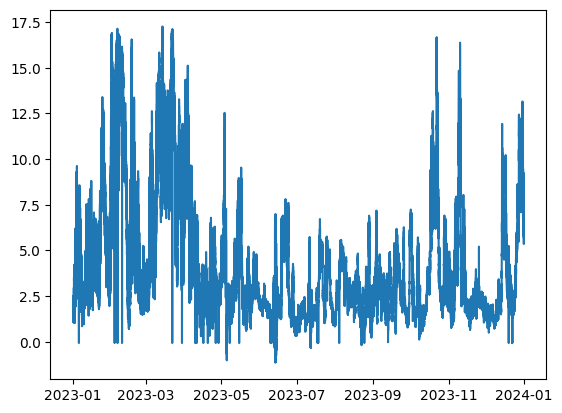

In [3]:
timestamps = []
pwv_values = []

with gzip.open(DATA_DIR / "wdb_query_eso.csv.gz", mode="rt", newline="") as fp:
	reader = csv.reader(fp)
	next(reader)
	next(reader)
	for row in reader:
		if len(row) == 3:
			p, t, pwv = row
			if pwv:
				t = dateutil.parser.parse(t)
				pwv = float(pwv)
				timestamps.append(t)
				pwv_values.append(pwv)

pwv_values = np.asarray(pwv_values)

plt.plot(timestamps, pwv_values)
plt.show()

The available PWV values follow a roughly log-normal distribution, a result consistent with previous [findings](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JD006731). Fitting a log-normal distribution to the data yields estimates of its parameters, which will be used later.

The graph below shows the real distribution of the data and compares it with the computed log-normal model.

In [175]:
plt.hist(pwv_values, bins=30, density=True)
#plt.show()

bounds = { "s": (0, 1), "scale": (0, 10) }
result = scipy.stats.fit(scipy.stats.lognorm, pwv_values, bounds=bounds, guess={ "s": 0.7, "scale": 3.1 })
params = result.params
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv_values.max(), step=pwv_values.max() / 100) + pwv_values.max() / 100
plt.plot(span, distribution.pdf(span))
#plt.show()

mean = pwv_values.mean()
std = pwv_values.std()
s2 = np.log((std / mean) ** 2 + 1)
s = np.sqrt(s2)
scale = mean * np.exp(-s2 / 2)
distribution = scipy.stats.lognorm(s=s, scale=scale)
span = np.arange(pwv_values.max(), step=pwv_values.max() / 100) + pwv_values.max() / 100
plt.plot(span, distribution.pdf(span))
#plt.show()

#distribution = scipy.stats.lognorm(s=0.7, scale=3.1)
#span = np.arange(pwv_values.max(), step=pwv_values.max() / 100) + pwv_values.max() / 100
#plt.plot(span, distribution.pdf(span))
plt.show()

print(params)
print(s, scale)

d:\Documents\AIExperiments\venv\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=28.49926737011875, pvalue=6.478324848425166e-07)

The following code generates a Markovian process of variables $V_i$ such that $V_{k+1}=p \cdot V_k+R_{k+1}$, where $R_i$ variables are indipendent with distribution $\mathcal{N}(0,1)$ and $0 \le p<1$.

When $k$ is large, $\mathrm{Var}(V_k)$ converges to $\frac{1}{1-p^2}$, due to the properties of geometric series. If $V_0$ has this same variance too and is a normally-distributed random variable independent of all $R_i$ variables, then $\mathrm{Var}(V_k)$ is constant and the sampling can start at any point.

A fact which is not immediately obvious is that any long segment of the generated sequence can be expected to have the same mean and variance as that of any $V_k$. This is a consequence of the fact that any two elements which are sufficiently far away in the sequence are nearly independent.

Multiplying every element of the sequence by $\sqrt{1-p^2}$ results in a new sequence of variables $S_i$ with a variance and standard deviation of 1.

The graph below generates and displays a random sequence in a graph, then shows the corresponding histogram, overlayed with the normal standard distribution for comparison.

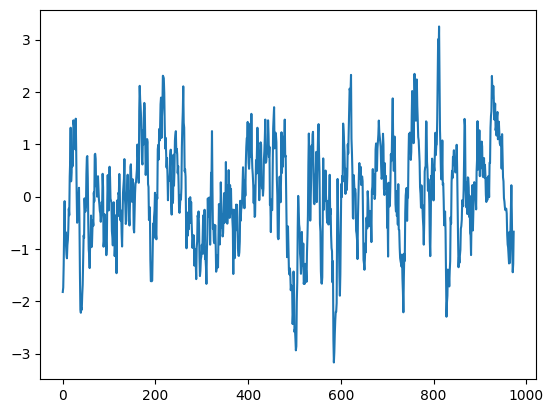

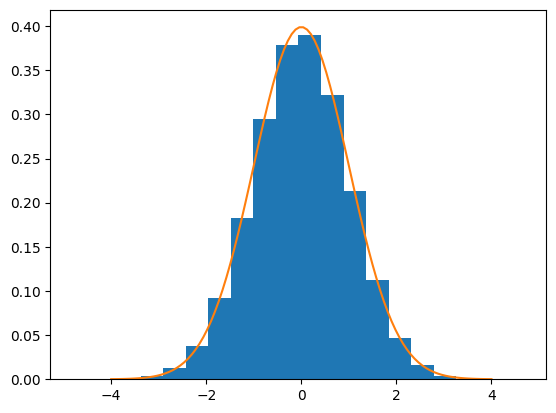

In [5]:
def gen_process(size, p):
	random = np.random.normal(size=size)
	v = random[0] / np.sqrt(1 - p ** 2)
	sequence = np.empty(size)
	sequence[0] = v
	for i in range(1, size):
		v = v * p + random[i]
		sequence[i] = v
	sequence *= np.sqrt(1 - p ** 2)
	return sequence

s = gen_process(1000000, 0.9)

plt.plot(s[:974])
plt.show()

plt.hist(s, bins=20, density=True)
#plt.show()

x = np.linspace(-4, 4, 100)
plt.plot(x, scipy.stats.norm.pdf(x))
plt.show()

The expected value of the difference between any two elements of a sequence generated as above is 0. However, its variance depends on their distance along the sequence.

$\mathrm{Var}(S_n - S_m)$ is 0 when $d=n-m=0$ (since they are really the same element) and then it grows monotonically with $d$. When $n \gg m$, $S_m$ and $S_n$ are nearly independent, so $S_n + (-S_m)$ is effectively the sum of two independent normally distributed random variables and its variance approaches 2, drawing a horizontal asymptote.

From the graph below it can be seen that the value of $p$ can be used to control the rate at which the standard deviation of the difference between two elements in the sequence grows with their distance: the lower $p$ is, the faster elements vary in the sequence.

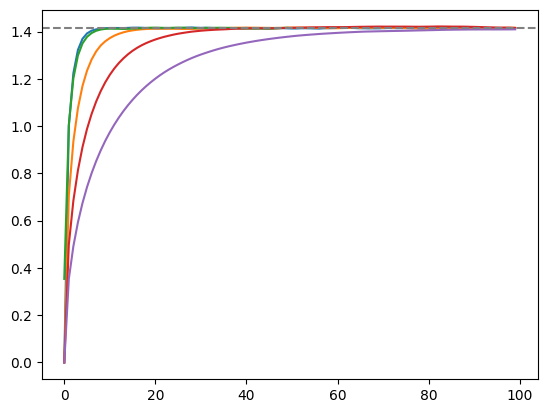

In [6]:
for exp in range(1, 5):
	sequence = gen_process(1000000, 1 - 0.5 ** exp)
	stds = [0]
	for i in range(1, 100):
		diffs = sequence[i:] - sequence[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()
	if exp == 2:
		stds_means = np.mean(stds.reshape(-1, 2), axis=1)
		plt.plot(stds_means)
		#plt.show()

plt.axhline(y=np.sqrt(2), linestyle="--", color="gray")

plt.show()

The following code generates a synthetic sequence of PVW values. The generatd values will follow a lognormal distribution. The parameters of the distribution and the pace of variation across the sequence must be set to realistic values.

The graph below shows a histogram of the generated data, overlined with the corresponding lognormal distribution as per the parameters used for generation and one fitted to the sequence.

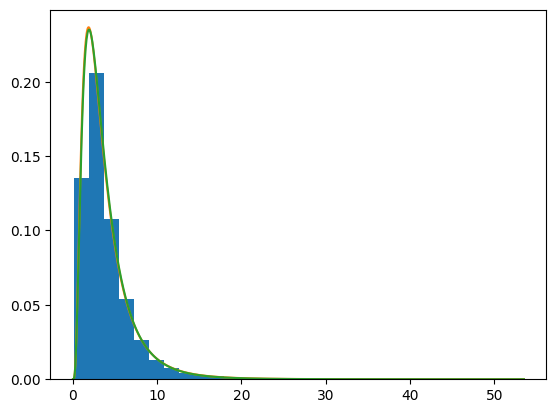

In [23]:
def gen_pwv(size, dt=1, pace=6e5, s=0.69598, scale=3.0862):
	pace /= dt
	p = pace / (pace + 1)
	sequence = gen_process(size, p)
	sequence *= s
	pwv = np.exp(sequence)
	pwv *= scale
	return pwv

pwv = gen_pwv(1000000, pace=1e3)

plt.hist(pwv, bins=30, density=True)
#plt.show()

distribution = scipy.stats.lognorm(0.69598, scale=3.0862)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
#plt.show()

params = scipy.stats.lognorm.fit(pwv)
distribution = scipy.stats.lognorm(*params)
span = np.arange(pwv.max(), step=pwv.max() / 1000) + pwv.max() / 1000
plt.plot(span, distribution.pdf(span))
plt.show()

The following code and graph show the effect of the `pace` parameter on how fast values vary throughout the generated sequence. It can be seen that higher values of the parameter correspond to slower variatons in the sequence.

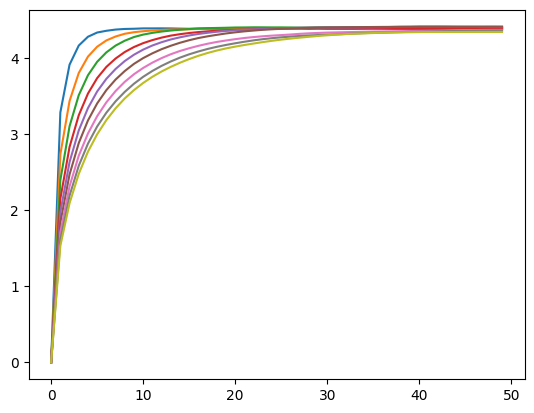

In [8]:
for pace in range(1, 10):
	pwv = gen_pwv(1000000, pace=pace)
	stds = [0]
	for i in range(1, 50):
		diffs = pwv[i:] - pwv[:-i]
		std = np.sqrt(np.sum(diffs ** 2) / diffs.size)
		stds.append(std)
	stds = np.asarray(stds)
	plt.plot(stds)
	#plt.show()

plt.show()

The following code extracts more or less contiguous intervals from the PWV measurements, which will be used later. rsedtfgyh

The following code extracts more or less contiguous intervals from the PWV measurements, which will be used later.

In [179]:
cond = deltas > 500
indices = np.empty(pwv_values.size, dtype=np.int32)

count = 0

indices[0] = 0

for i in range(cond.size):
	count += cond[i]
	indices[i + 1] = count

n_intervals = indices[-1]

intervals = []

for i in range(1, n_intervals):
	selected = indices == i
	if selected.sum() >= 100:
		interval_x = instants[selected]
		interval_y = pwv_values[selected]
		intervals.append((interval_x, interval_y))

The following code selects those contiguous intervals in PWV data whose duration falls within a certain range.

The graph displays 10 selected intervals at random

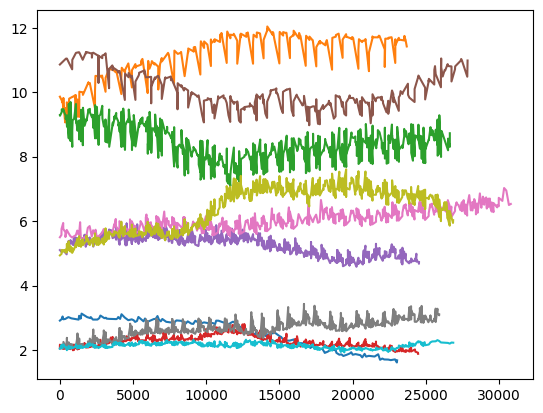

In [182]:
selected_intervals = [(i_x, i_y) for i_x, i_y in intervals if 20000 < i_x[-1] - i_x[0] < 40000]

samples = random.sample(selected_intervals, 10)

for i_x, i_y in samples:
	plt.plot(i_x - i_x[0], i_y)
	#plt.show()

plt.show()

The following code justifies the value $6 \times 10^5$ for the `pace` parameter. It can be seen that, using this value for generation, a real PWV interval, among the previously selected ones, has a standard deviation lower than that of a generated sequence of the same length about half of the times and a higher one the other half.

In [191]:
count = [0, 0]

for i in range(100):
	pwv1 = gen_pwv(40000, pace=6e5)

	for i_x, i_y in selected_intervals:
		size = int(i_x[-1] - i_x[0])
		std1 = pwv1[:size].std()
		std_real = i_y.std()
		if std_real < std1:
			count[0] += 1
		else:
			count[1] += 1

print(count)

[5963, 5937]


The following code exemplifies the generation of PWV sequences with a duration of 5 hours represented trough 59 samples.

From the graph below it can be seen that sequences with higher values also generally display more variation. The same pattern can be seen in real sequences shown previously.

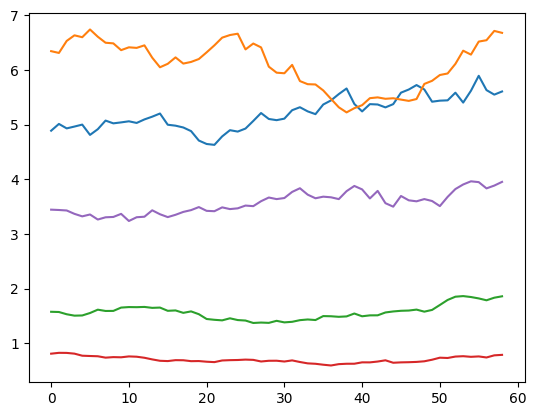

In [15]:
timespan = 5 * 60 * 60
size = 59

for i in range(5):
	pwv = gen_pwv(size, dt=timespan / size, pace=6e5)
	plt.plot(pwv)
	#plt.show()

plt.show()